In [125]:
import matplotlib

In [240]:
import seaborn as sns                                                                                    
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
import pickle
from scipy import stats

%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

rate = '1000'
exp_base_folder = os.path.join('/home/maxdml/datacenter-OS/src/python/plot_utils/data/', rate, '')

pd.set_option('float_format', '{:f}'.format)

cache = {}
# cache['exp_name']['latency_name']['pickle']
# cache['exp_name']['latency_name']['data']
# cache['exp_name']['throughput']

In [289]:
def read_csv(csvfile, reset_time=True, second_ts=True, prune=True):
    df = pd.read_csv(csvfile, delimiter='\t').sort_values('TIME')
    if reset_time:
        df.TIME -= min(df.TIME)
    if second_ts:
        df.TIME /= 1e9
    if prune:
        value_df = df.loc[:, df.columns == 'VALUE']
        high = int(value_df.quantile(q=.9999))
        value_df = value_df.apply(lambda x: x[x < high])
        df = pd.concat([df.loc[:, 'TIME'], value_df], axis=1)
        df.dropna(inplace=True)
    return df

#Note: reset the cache in plot_setup means reset pickle entries only
#TODO:
# - have this take the type of plot too
# - Fix pickle load :(
def plot_setup(setups, data_label, stacking=False, reset_cache=False):
    if stacking:
        nplots = 1
    else:
        nplots = len(setups)      
        
    fig, axs = plt.subplots(1, nplots, squeeze=False, sharey=True, sharex=True)
    for i, setup in enumerate(setups.keys()):
        index = i % nplots
        if not reset_cache and 'pickle' in cache[setup][data_label] and os.path.getsize(cache[setup][data_label]['pickle']) > 0:
            fig.delaxes(axs[0][index])
            pickle.load(open(cache[setup][data_label]['pickle'], 'rb'))
        else:
            sns.distplot(setups[setup][data_label].VALUE, ax=axs[0][index], label=setup, kde=True,  kde_kws=dict(cumulative=True), bins=100)
            axs[0][index].set(xlabel='latency (ns)', ylabel='#requests')
            if stacking:
                axs[0][index].set_title('{} latency'.format(data_label))
            else:
                axs[0][index].set_title('{} latency: {}'.format(data_label, setup))

            axs[0][index].ticklabel_format(style='plain')
            axs[0][index].legend()

            pickle.dump(axs[0], open(setup + '-' + data_label + '.pickle', 'wb'))
            cache[setup][data_label]['pickle'] = setup + '-' + data_label + '.pickle'

        
    # fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True)
    # for i, setup in enumerate(setups.keys()):
    #     sns.scatterplot(x = setups[setup]['e2e'].TIME, y='VALUE', data=setups[setup]['e2e'], palette='colorblind', ax=axs[0][i])
    #     axs[0][i].set(xlabel='Timestamp', ylabel='latency (ns)')
    #     axs[0][i].set_title('End to end latency: {}'.format(setup))
    # fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True, sharex=True)
    # for i, setup in enumerate(setups.keys()):
    #     sns.boxplot(x=setups[setup]['e2e'].VALUE, ax=axs[0][i])
    #     axs[0][i].set(xlabel='latency (ns)')
    #     axs[0][i].set_title('End to end latency: {}'.format(setup))

# reset the cache here only means getting ride of the dataframes
def prepare_data(exps, latencies, prune=True, tail=False, reset_cache=False):               
    setups = {}
    for exp in exps:
        setups[exp] = {}
        exp_folder = os.path.join(exp_base_folder, exp, '')
        
        for lat in latencies:
            if not reset_cache and 'data' in cache[exp][lat]:
                setups[exp][lat] = cache[exp][lat]['data']
            else:
                filename = os.path.join(exp_folder, 'rate_client', exp + '_' + lat)
                setups[exp][lat] = read_csv(filename)
                if prune:
                    setups[exp][lat] = setups[exp][lat][setups[exp][lat].VALUE < setups[exp][lat].VALUE.quantile(.9999)]
                if tail:
                    setups[exp][lat] = setups[exp][lat][setups[exp][lat].VALUE > setups[exp][lat].VALUE.quantile(.90)]
                cache[exp][lat]['data'] = setups[exp][lat]
                
        # Ethq data
        if not reset_cache and 'throughput' in cache[exp]:
            setups[exp]['throughput'] = cache[exp]['throughput']
        else:
            filename = os.path.join(exp_folder, 'ethq', 'ethq.log')
            df = pd.read_csv(filename, delimiter='\t')
            df.time -= min(df.time)
            df.time /= 1e9
            df.set_index('time', inplace=True)
            df = df[df.NIC.isin(['eno5-1', 'eno5-2', 'eno5-5', 'eno5-6']) & ((df.T.drop('NIC') != 0).any())]
            setups[exp]['throughput'] = df
            cache[exp]['throughput'] = df

# Apparently those are disk cache stats...
#         cachestats_filename = exp_folder + 'cachestat/cachestats.csv'
#         df = pd.read_csv(cachestats_filename, delimiter='\t')
#         df.dropna(inplace=True)
#         df['WRITE_HIT%'] = df['WRITE_HIT%'].apply(lambda x: float(x.strip('%')))
#         df['READ_HIT%'] = df['READ_HIT%'].apply(lambda x: float(x.strip('%')))
#         df = df[(df.HITS > 0) | (df.MISSES > 0) | (df.DIRTIES > 0) | (df['READ_HIT%'] > 0) | (df['WRITE_HIT%'] > 0)]
#         setups[exp]['cachestats'] =  df
#         setups[exp]['cachestats'].TIME -= min(setups[exp]['cachestats'].TIME)
    
    return setups

def setup_cache(exps, lats):
    for exp in exps:
        cache[exp] = {}
        for lat in lats:
            cache[exp][lat] = {}

#reset the cache here means refreshing the whole experiment entries
def plot_all(exps, reset_cache=False, stacking=True):                
    lats = ['end-to-end', 'connect', 'send','receive']
    if reset_cache:
        for exp in exps:
            cache[exp] = {}
            for lat in lats:
                cache[exp][lat] = {}
    
    setups = prepare_data(exps, lats)

    # Plots
    ###### latencies
#     for l in lats:
#         plot_setup(setups, l, stacking=stacking, reset_cache=reset_cache)

    # Merge all the throughput DF together. Hue will be setup
    tps = []
    for setup in setups:
        setups[setup]['throughput']['exp'] = setup     
        tps.append(setups[setup]['throughput'])
    df = pd.concat(tps)
    fig, axs = plt.subplots(1, 2, squeeze=False, sharey=False)
    sns.lineplot(x=df.index, y='TX Mbps', hue='exp', data=df, ax=axs[0][0], ci=None)
    sns.lineplot(x=df.index, y='RX Mbps', hue='exp', data=df, ax=axs[0][1], ci=None)
    
    ###### Cachestat numbers
#     cols = s[exps[0]]['cachestats'].drop('TIME', axis=1).columns
#     fig, axs = plt.subplots(len(cols), len(exps), squeeze=False, sharex=True)
#     for i, setup in enumerate(s.keys()):
#         for j, col in enumerate(cols):
#             sns.scatterplot(x = s[setup]['cachestats'].TIME, y=col, data=s[setup]['cachestats'], palette='colorblind', ax=axs[j][i])
#             if i > 0:
#                 axs[j][i].set(xlabel='Timestamp (s)', ylabel='')
#             else:
#                 axs[j][i].set(xlabel='Timestamp (s)', ylabel='{}'.format(col))
#         axs[0][i].set_title('Cache statistics: {}'.format(setup))

<IPython.core.display.Javascript object>


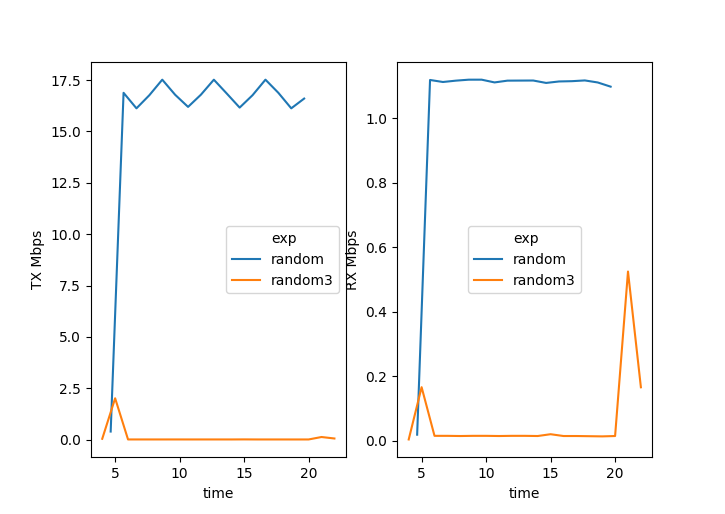

In [293]:
exps = ['random', 'random3']
plot_all(exps, reset_cache=False)

<IPython.core.display.Javascript object>


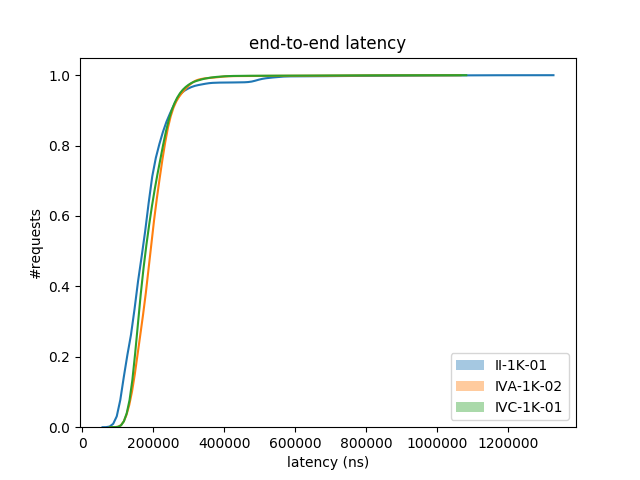

<IPython.core.display.Javascript object>


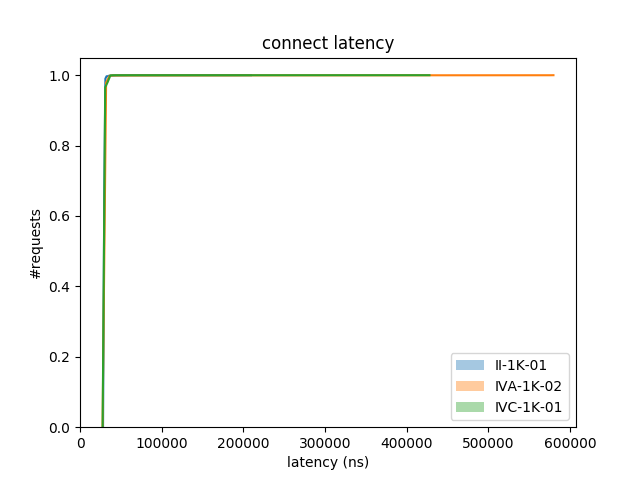

<IPython.core.display.Javascript object>


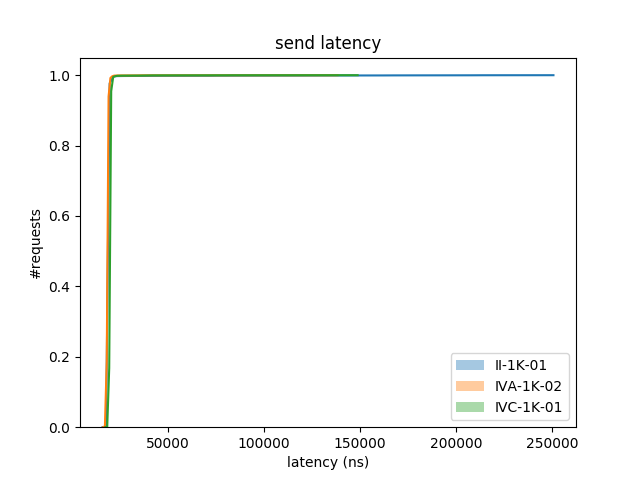

<IPython.core.display.Javascript object>


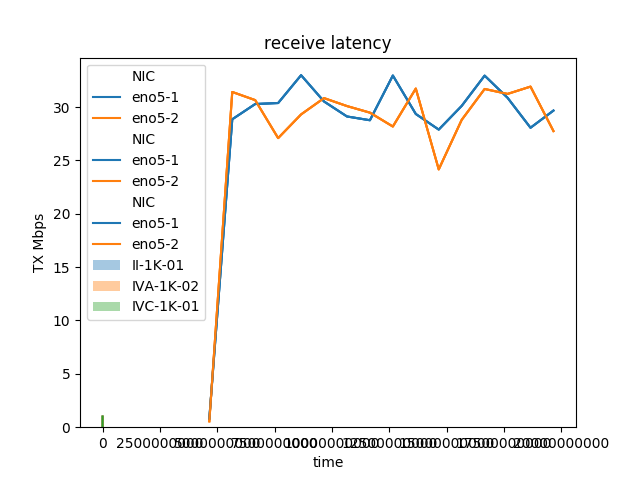

In [180]:
exps = ['II-1K-01', 'IVA-1K-02', 'IVC-1K-01']
plot_all(exps, reset_cache=True)

In [ ]:
#  EXEC  : instructions per nominal CPU cycle
#  IPC   : instructions per CPU cycle
#  FREQ  : relation to nominal CPU frequency='unhalted clock ticks'/'invariant timer ticks' (includes Intel Turbo Boost)
#  AFREQ : relation to nominal CPU frequency while in active state (not in power-saving C state)='unhalted clock ticks'/'invariant timer ticks while in C0-state'  (includes Intel Turbo Boost)
#  L3MISS: L3 (read) cache misses 
#  L3HIT : L3 (read) cache hit ratio (0.00-1.00)
#  L3MPI : number of L3 (read) cache misses per instruction
#  L2MPI : number of L2 (read) cache misses per instruction
#  READ  : bytes read from main memory controller (in GBytes)
#  WRITE : bytes written to main memory controller (in GBytes)
#  L3OCC : L3 occupancy (in KBytes)

##TODO that goes into prepare_data

pd.set_option('display.max_columns', None)

stats = ['EXEC', 'IPC', 'L3MISS', 'L2MISS', 'L3HIT', 'L3MPI', 'L2MPI', 'L3OCC']
core_to_comp = {'1': 'network', '2': 'http', '3': 'http'}

raw_pcm_df = pd.read_csv('data/test.csv', delimiter=';')
raw_pcm_df.Time = pd.to_datetime(raw_pcm_df.Time).values.astype(np.int64) // 10**9
raw_pcm_df.Time -= min(raw_pcm_df.Time)

cores_list = [1,2,3]
cols = ['Date', 'Time']
for core in cores_list:
    new_cols = [stat+'.{}'.format(core) for stat in stats]
    cols.extend(new_cols)
pcm_df = raw_pcm_df[cols]
pcm_df

##TODO that goes into plot_data

fig, axs = plt.subplots(len(stats), 1, squeeze=False, sharey=False, sharex=True) # nrows will be == to len(core_to_compname.keys())
for i in range(len(stats)):
    stat_names = [stats[i]+'.{}'.format(core_id) for core_id in core_to_comp.keys()]
    for c, stat in enumerate(stat_names):
        sns.scatterplot(x = pcm_df.Time, y=stat, data=pcm_df, palette='colorblind', ax=axs[i][0], legend=False)
        axs[i][0].set(xlabel='Time')
        axs[i][0].set_title('{}'.format(stat), fontsize=6)
        ylimit = max(pcm_df[stat]) + max(pcm_df[stat]) * 0.1
        axs[i][0].set_ylim(0,ylimit)
        axs[i][0].set_ylabel('')